# Import Library

In [1]:
import os
import pickle
import math
import mne
import scipy.stats
import numpy as np
import scipy.io as sio
from scipy.stats import rankdata
from scipy.fftpack import fft,ifft
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

## Import Data

In [2]:
dataset_dir = "/home/DEAP/s01.mat"
data = sio.loadmat(dataset_dir)
datasets = data['data']
labels = data['labels']

## Preprocessing

In [3]:
data_in = datasets[0:40,0:32,0:8064]

In [4]:
base_signal = (data_in[0:40,0:32,0:128]+data_in[0:40,0:32,128:256]+data_in[0:40,0:32,256:384])/3
data = data_in[0:40,0:32,384:8064]

In [5]:
for i in range(0,60):
    data[0:40,0:32,i*128:(i+1)*128]=data[0:40,0:32,i*128:(i+1)*128]-base_signal

In [6]:
labels = labels.transpose(1,0)

In [7]:
valence = labels[0]
arousal = labels[1]

In [8]:
def label_preprocess(emotion):
    for i in range(0,40):
        if emotion[i]>5:
            emotion[i]=1
        else:
            emotion[i]=0
    return emotion

In [9]:
label = label_preprocess(valence)

In [10]:
data.shape

(40, 32, 7680)

In [11]:
label.shape

(40,)

In [12]:
data_eeg=np.zeros([40,60,32,128])
label_eeg=np.zeros([40,60,1])
for i in range(0,40):
    for j in range(0,60):
        data_eeg[i][j]=data[i,0:32,i*128:(i+1)*128]
        label_eeg[i][j]=label[i]

In [13]:
data_eeg = data_eeg.reshape(-1,32,128)
label_eeg = label_eeg.astype(np.int64).reshape(-1)

In [14]:
data_eeg.shape

(2400, 32, 128)

## Feature Extraction

In [14]:
param = {'stftn':128,'fStart':[4,8,14,31],'fEnd':[7,13,30,50],'window':1,'fs':128}

In [15]:
def DE_PSD(data,stft_para):
    '''
    compute DE and PSD
    --------
    input:  data [n*m]          n electrodes, m time points
            stft_para.stftn     frequency domain sampling rate
            stft_para.fStart    start frequency of each frequency band
            stft_para.fEnd      end frequency of each frequency band
            stft_para.window    window length of each sample point(seconds)
            stft_para.fs        original frequency
    output: psd,DE [n*l*k]        n electrodes, l windows, k frequency bands
    '''
    #initialize the parameters
    STFTN=stft_para['stftn']
    fStart=stft_para['fStart']
    fEnd=stft_para['fEnd']
    fs=stft_para['fs']
    window=stft_para['window']

    WindowPoints=fs*window

    fStartNum=np.zeros([len(fStart)],dtype=int)
    fEndNum=np.zeros([len(fEnd)],dtype=int)
    for i in range(0,len(stft_para['fStart'])):
        fStartNum[i]=int(fStart[i]/fs*STFTN)
        fEndNum[i]=int(fEnd[i]/fs*STFTN)

    #print(fStartNum[0],fEndNum[0])
    n=data.shape[0]
    m=data.shape[1]
    #l=int(m/fs)
    
    #print(m,n,l)
    psd = np.zeros([n,len(fStart)])
    de = np.zeros([n,len(fStart)])
    #Hanning window
    Hlength=window*fs
    #Hwindow=hanning(Hlength)
    Hwindow= np.array([0.5 - 0.5 * np.cos(2 * np.pi * n / (Hlength+1)) for n in range(1,Hlength+1)])

    WindowPoints=fs*window
    dataNow=data[0:n]
    for j in range(0,n):
        temp=dataNow[j]
        Hdata=temp*Hwindow
        FFTdata=fft(Hdata,STFTN)
        magFFTdata=abs(FFTdata[0:int(STFTN/2)])
        for p in range(0,len(fStart)):
            E = 0
            #E_log = 0
            for p0 in range(fStartNum[p]-1,fEndNum[p]):
                E=E+magFFTdata[p0]*magFFTdata[p0]
            #    E_log = E_log + log2(magFFTdata(p0)*magFFTdata(p0)+1)
            E = E/(fEndNum[p]-fStartNum[p]+1)
            psd[j][p] = E
            de[j][p] = math.log(100*E,2)
            #de(j,i,p)=log2((1+E)^4)
    
    return psd,de

In [16]:
de=np.zeros([40*60,32,4])
for i in range(0,40*60):
    _,de[i]=DE_PSD(data_eeg[i],param)

In [17]:
de=de.transpose(2,0,1)

In [18]:
de.shape

(4, 2400, 32)

## DBN

In [81]:
def train_DBN(data,label,n_iter=10):
    X_train, X_test, Y_train, Y_test = train_test_split(data, label,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0)
    X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)  # 0-1 scaling
    X_test = (X_test - np.min(X_test, 0)) / (np.max(X_test, 0) + 0.0001)  # 0-1 scaling
    logistic = linear_model.LogisticRegression(C=100)
    rbm1 = BernoulliRBM(n_components=200, learning_rate=0.06, n_iter=n_iter, verbose=1, random_state=101)
    rbm2 = BernoulliRBM(n_components=200, learning_rate=0.06, n_iter=n_iter, verbose=1, random_state=101)
    DBN2 = Pipeline(steps=[('rbm1', rbm1),('rbm2', rbm2),('logistic', logistic)])
    DBN2.fit(X_train, Y_train)
    accuracy = metrics.accuracy_score(
            Y_test,
            DBN2.predict(X_test))
    print("Logistic regression using RBM features Accuracy:\n%s\n" % (accuracy))
    coef1 = rbm1.components_.transpose(1,0)
    print(coef1.shape)
    coef2 = rbm2.components_.transpose(1,0)
    coef3 = logistic.coef_.transpose(1,0)
    IG = np.dot(np.dot(coef1,coef2),coef3)
    return IG,accuracy

In [83]:
IG, accuracy = train_DBN(de[3],label_eeg,n_iter=1)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.75, time = 1.09s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.31, time = 2.21s
Logistic regression using RBM features Accuracy:
0.5895833333333333

(32, 200)


## Visualization

In [23]:
def topomap(IG):
    norm = scipy.stats.zscore(IG)
    biosemi_montage = mne.channels.make_standard_montage('biosemi32')
    n_channels = len(biosemi_montage.ch_names)
    fake_info = mne.create_info(ch_names=biosemi_montage.ch_names,sfreq=128.,
                                ch_types='eeg')
    rng = np.random.RandomState(0)
    data_plot = norm[0:32,0:1]
    fake_evoked = mne.EvokedArray(data_plot, fake_info)
    fake_evoked.set_montage(biosemi_montage)
    mne.viz.plot_topomap(fake_evoked.data[:, 0], fake_evoked.info,
                     show=False)

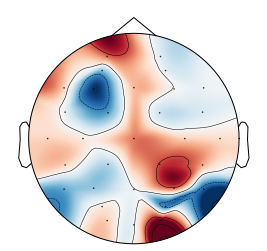

In [24]:
topomap(IG)

## ROAR

In [66]:
def ROAR_DBN2(data,label):
    # Integrated Gradients
    acc=[]
    feature_importance=[]
    gradient,accuracy = train_DBN(data,label,n_iter=2)
    acc.append(accuracy)
    feature_importance.append(gradient)
    rank = rankdata(IG)
    min_index=np.where(rank==32)
    new_data = de[3].transpose(1,0)
    print(new_data.shape)
    new_label = label_eeg
    min = new_data[min_index]
    print(min.shape)
    for i in range(1,33):
        print("{}trial".format(i))
        trans=np.where(rank<=i)
        for i in trans:
            new_data[i]=min
            new_label[i] = label_eeg[i]
        pre_data=new_data.transpose(1,0)
        print(pre_data.shape)
        gradient,accuracy = train_DBN(pre_data,new_label,n_iter=2)
        acc.append(accuracy)
        feature_importance.append(gradient)
    return acc,feature_importance

In [67]:
acc, feature = ROAR_DBN2(de[3],label_eeg)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.26, time = 1.09s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -4.40, time = 1.70s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.19, time = 2.23s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.32, time = 3.10s
Logistic regression using RBM features Accuracy:
0.5375

(32, 2400)
(1, 2400)
(2400, 32)
[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.26, time = 1.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -4.40, time = 1.72s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.19, time = 2.19s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.32, time = 3.33s
Logistic regression using RBM features Accuracy:
0.5375

(2400, 32)
[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.27, time = 1.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -4.32, time = 1.71s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.19, time = 2.22s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.32, time = 3.10s
Logistic regres

[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.22, time = 2.25s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.36, time = 3.15s
Logistic regression using RBM features Accuracy:
0.49375

(2400, 32)
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.76, time = 1.16s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.71, time = 1.72s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.23, time = 2.47s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.34, time = 3.34s
Logistic regression using RBM features Accuracy:
0.49375

(2400, 32)
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.75, time = 1.12s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3.67, time = 1.72s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.22, time = 2.29s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -138.31, time = 3.16s
Logistic regression using RBM features Accuracy:
0.49375

(2400, 32)
[BernoulliRBM] Iteration 1, pseudo-likelihood = -3.71, time = 1.12s
[BernoulliRBM] Iteration 2, pseud

In [68]:
acc

[0.5375,
 0.5375,
 0.5125,
 0.4979166666666667,
 0.4979166666666667,
 0.4979166666666667,
 0.4979166666666667,
 0.4979166666666667,
 0.4979166666666667,
 0.475,
 0.475,
 0.5104166666666666,
 0.5104166666666666,
 0.5104166666666666,
 0.5104166666666666,
 0.5104166666666666,
 0.5104166666666666,
 0.49375,
 0.49375,
 0.49375,
 0.49375,
 0.49375,
 0.5104166666666666,
 0.49375,
 0.49375,
 0.49375,
 0.51875,
 0.51875,
 0.53125,
 0.575,
 0.575,
 0.5895833333333333,
 0.5895833333333333]

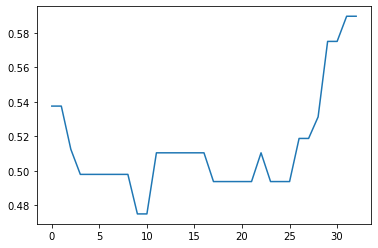

In [71]:
import matplotlib.pyplot as plt
plt.plot(acc)

In [72]:
len(feature)

33

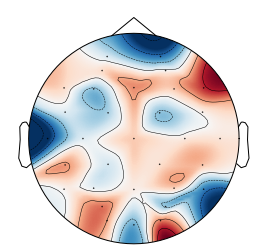

In [77]:
topomap(feature[0])

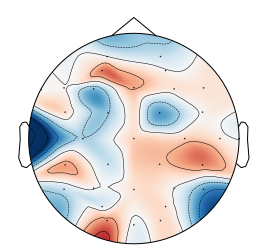

In [80]:
topomap(feature[32])